<a href="https://colab.research.google.com/github/Fidelisaboke/robust-nids/blob/feat%2Fbaseline-model/notebooks/04_baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Required Libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Standard library for mathematical operations
import math

# Progress
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# ML Models (Classifiers)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Unsupervised learning
import tensorflow as tf
from tensorflow.keras import layers, models

# For saving models
import joblib

## Constants and Configuration

In [3]:
# Clean CSV Path
CLEAN_CSV_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/cleaned_data.csv"

# Scaler
SCALER_PATH = "/content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/scaler.pkl"

## Load the Dataset

In [4]:
df = pd.read_csv(CLEAN_CSV_PATH)
df.head()

,Flow Duration,Flow Bytes/s,Flow Packets/s,Fwd Packet Length Max,Fwd Packet Length Min,Packet Length Std,Bwd Init Win Bytes,FWD Init Win Bytes,Fwd Seg Size Min,Idle Std,Idle Mean,SYN Flag Count,ACK Flag Count,Total Fwd Packet,Total Bwd packets,Label,Traffic Subtype
0,52601173.0,5522.709541,66.424374,1318.0,0.0,93.643930,2068.0,65280.0,32.0,0.000000,0.0,2.0,3493.0,1701.0,1793.0,0,Audio
1,119106942.0,24.599742,0.780811,41.0,0.0,27.063135,502.0,502.0,32.0,1737.400069,5001511.0,0.0,93.0,36.0,57.0,0,Audio
2,5589.0,22186.437645,357.845768,124.0,124.0,71.591433,502.0,501.0,32.0,0.000000,0.0,0.0,2.0,1.0,1.0,0,Audio
3,118166562.0,5969.142100,68.784264,1348.0,0.0,133.693257,4708.0,65280.0,32.0,0.000000,0.0,2.0,8127.0,3932.0,4196.0,0,Audio
4,119988385.0,4459.064934,56.838835,9.0,9.0,17.228724,0.0,0.0,8.0,0.000000,0.0,0.0,0.0,25.0,6795.0,0,Audio


## Separate features from labels

In [5]:
# Separate features and labels
X = df.drop(columns=["Label", "Traffic Subtype"])
y = df["Label"] # Target for binary classification

## Train-test split
- Split: 70% training, 15% testing, 15% validation
- Statification will be applied to preserve class balance

In [6]:
# Split into train (70%) and val + test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the 30% into val (15%) and test (15%)
X_val, X_test, y_val, y_Test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (137295, 15)
Validation size: (29420, 15)
Test size: (29421, 15)


## Feature Scaling


In [7]:
# Create scaler instance
scaler = MinMaxScaler()

# Fit on X_train, transform X_train, X_val, X_test
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Save the scaler for use later

In [8]:
try:
  joblib.dump(scaler, SCALER_PATH)
  print(f"Scaler saved to: {SCALER_PATH}")
except Exception as e:
  print(f"Error saving scaler: {e}")

Scaler saved to: /content/drive/MyDrive/Datasets/TII-SSRC-23/Artifacts/scaler.pkl


## Supervised Learning
- The following classifiers will be trained to establish a fair baseline:
1. Logistic Regression
2. Random Forest
3. XGBoost
4. SVM (RBF kernel) (for non-linear separation)
5. MLP (shallow neutral net)

### Model Training and Validation

In [9]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200)
}

# Apply SMOTE to training set (optional toggle)
use_smote = False
if use_smote:
  smote = SMOTE(random_state=42)
  X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
else:
  X_train_bal, y_train_bal = X_train_scaled, y_train
  print("Skipping SMOTE...")

# Results list
results = []

for name, model in tqdm(models.items(), desc="Training Models", unit="model"):
  # Fit on training set
  model.fit(X_train_bal, y_train_bal)

  # Validation performance
  y_val_pred = model.predict(X_val_scaled)
  y_val_prob = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None

  print(f"\n\n{name} Validation Results:")
  print(classification_report(y_val, y_val_pred))

  # Compile metrics
  metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Recall": recall_score(y_val, y_val_pred, average="binary", pos_label=1),
        "F1": f1_score(y_val, y_val_pred, average="binary", pos_label=1),
        "Confusion Matrix": confusion_matrix(y_val, y_val_pred)
  }

  if y_val_prob is not None:
    print("ROC-AUC (val): ", roc_auc_score(y_val, y_val_prob))
    metrics["ROC-AUC"] = roc_auc_score(y_val == 1, y_val_prob)
  else:
    metrics["ROC-AUC"] = None

  results.append(metrics)

Skipping SMOTE...


Training Models:  20%|██        | 1/5 [00:00<00:02,  1.93model/s]



Logistic Regression Validation Results:
              precision    recall  f1-score   support

           0       0.86      0.30      0.44       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.93      0.65      0.72     29420
weighted avg       0.99      1.00      0.99     29420

ROC-AUC (val):  0.9062487645836743


Training Models:  40%|████      | 2/5 [00:26<00:46, 15.41s/model]



Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.98      0.96      0.97     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9842352456056406


Training Models:  60%|██████    | 3/5 [00:27<00:18,  9.02s/model]



XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.99      0.96      0.97     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9997501245831495


Training Models:  80%|████████  | 4/5 [05:24<02:02, 122.44s/model]



SVM Validation Results:
              precision    recall  f1-score   support

           0       0.93      0.63      0.75       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.96      0.82      0.88     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9786144226424179


Training Models: 100%|██████████| 5/5 [07:54<00:00, 94.82s/model] 



MLP Validation Results:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       193
           1       1.00      1.00      1.00     29227

    accuracy                           1.00     29420
   macro avg       0.96      0.95      0.95     29420
weighted avg       1.00      1.00      1.00     29420

ROC-AUC (val):  0.9909193908464582


## Results Dataframe

In [10]:
# Convert results into a pandas dataframe
results_df = pd.DataFrame(results)

# Remove confusion matrix for results display
print(results_df.drop("Confusion Matrix", axis=1))

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.995071   0.995367  0.999692  0.997525  0.906249
1        Random Forest  0.999218   0.999419  0.999795  0.999607  0.984235
2              XGBoost  0.999252   0.999419  0.999829  0.999624  0.999750
3                  SVM  0.997281   0.997576  0.999692  0.998633  0.978614
4                  MLP  0.998776   0.999350  0.999418  0.999384  0.990919


## Visualization of Metrics

### Function to plot model comparison

In [11]:
def plot_model_comparison(results_df: pd.DataFrame):
  """
  Generates and displays a bar plot comparing classifiers' performance
  across various smetrics.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.barplot(data=df_melt, x="Metric", y="Score", hue="Model", palette="Set2")
  plt.ylim(0, 1)
  plt.title("Model Validation Performance", fontsize=14)
  plt.ylabel("Score")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

### Function to plot metric trends

In [12]:
def plot_metric_trends(results_df: pd.DataFrame):
  """
  Generates and displays a line plot the trend of metrics across models.
  """
  df_melt = results_df.melt(
      id_vars=["Model"],
      value_vars=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
      var_name="Metric", value_name="Score"
  )

  plt.figure(figsize=(10,6))
  sns.lineplot(data=df_melt, x="Metric", y="Score", hue="Model", marker="o")
  plt.ylim(0, 1)
  plt.title("Model Metrics Trend", fontsize=14)
  plt.ylabel("Score")
  plt.show()


### Function for generating heatmap for quick overview

In [13]:
def plot_metric_heatmap(results_df: pd.DataFrame):
  """
  Generates and displays a heatmap of validation metrics.
  """
  plt.figure(figsize=(8,5))
  sns.heatmap(results_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".2f")
  plt.title("Validation Metrics Heatmap", fontsize=14)
  plt.show()


### Function for generating confusion matrix

In [14]:
def plot_confusion_matrix(results_df: pd.DataFrame):
    """
    Generates and displays confusion matrices for each model.
    """
    n_models = len(results_df)
    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
    axes = axes.flatten()  # Flatten to 1D for easy indexing

    for ax, (_, row) in zip(axes, results_df.iterrows()):
        cm = row["Confusion Matrix"]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False,
                    xticklabels=["Benign", "Malicious"],
                    yticklabels=["Benign", "Malicious"])

        ax.set_title(f"{row['Model']}\nConfusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    # Hide any unused subplots
    for ax in axes[len(results_df):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Running functions to visualize metrics

#### Metrics Comparison

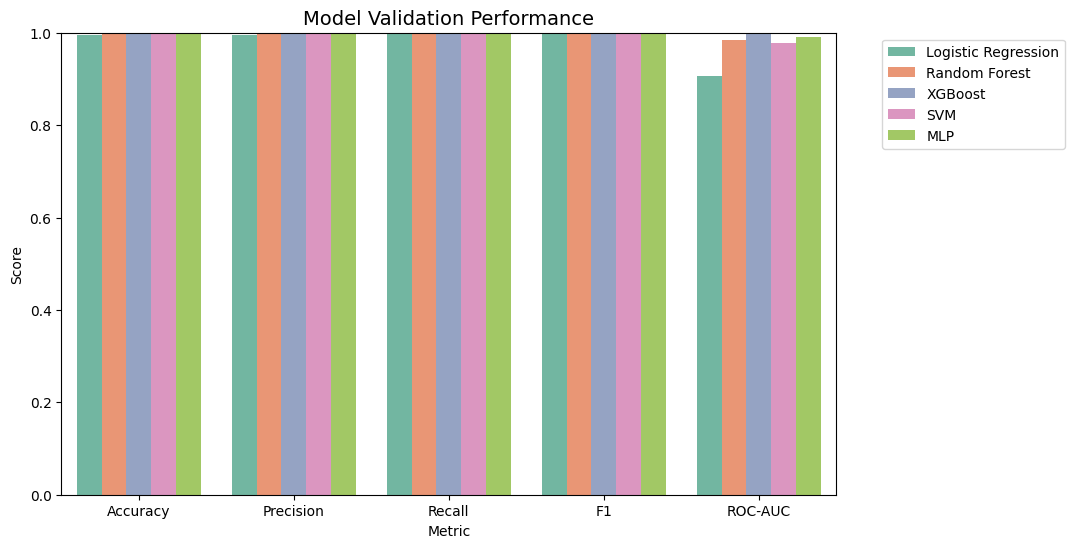

In [15]:
plot_model_comparison(results_df)


### Metric Trends

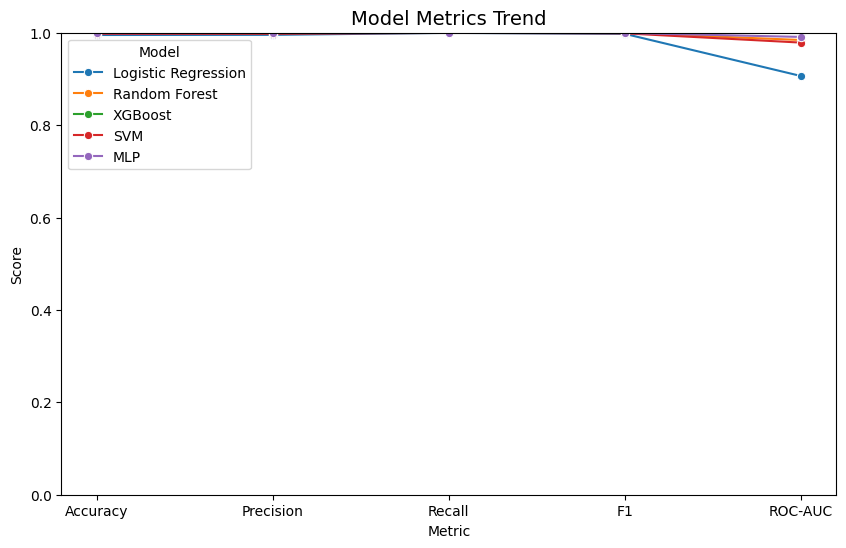

In [16]:
plot_metric_trends(results_df)

### Metric Heatmap

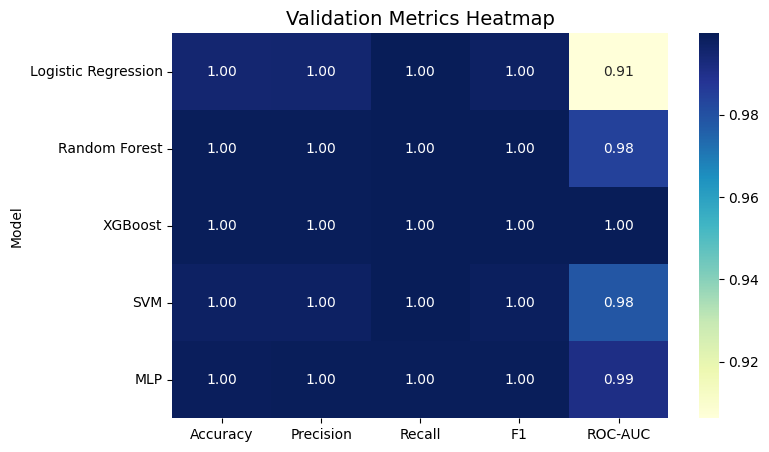

In [17]:
plot_metric_heatmap(results_df.drop("Confusion Matrix", axis=1))

### Confusion matrix

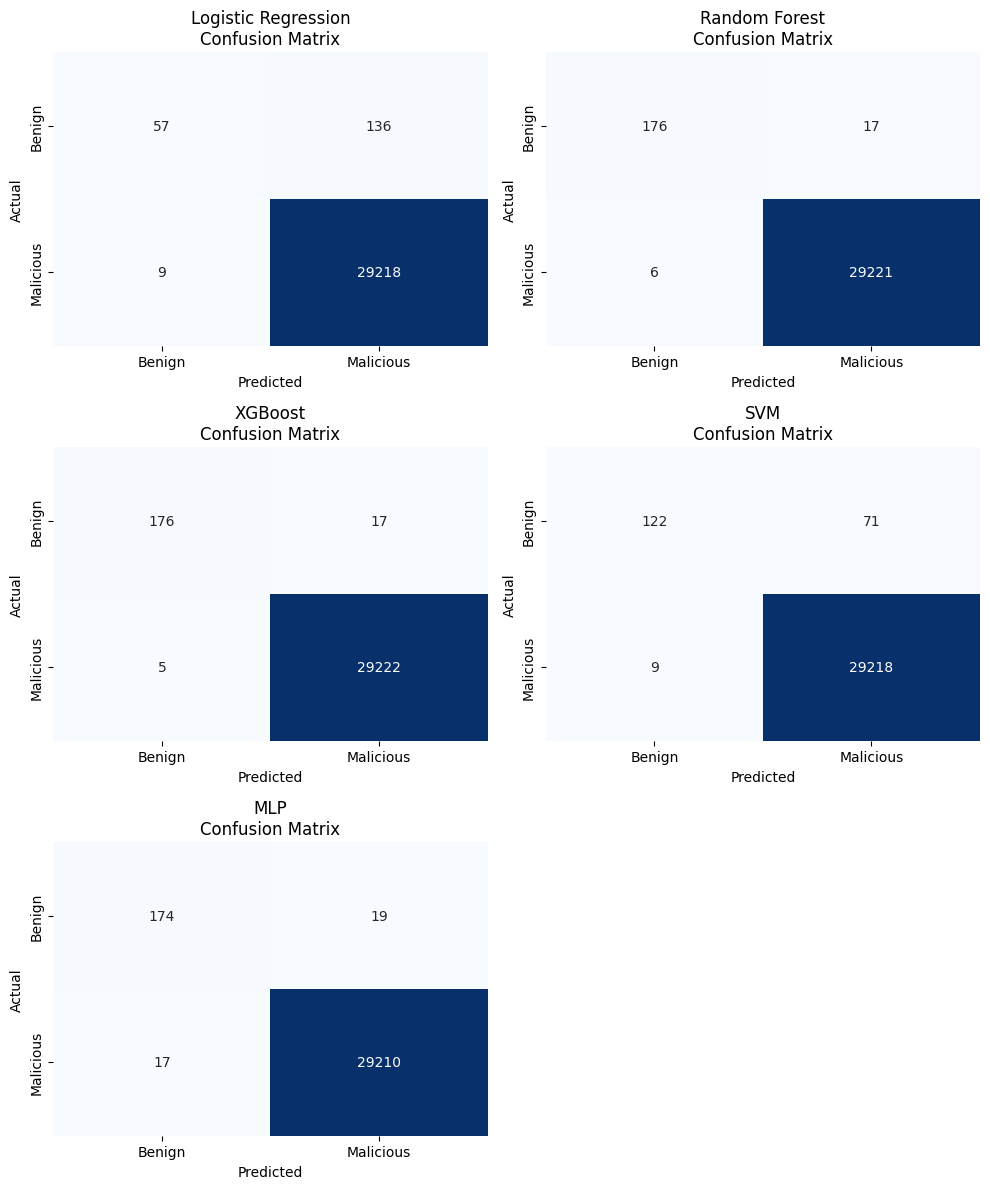

In [18]:
plot_confusion_matrix(results_df)